# Семинар 9 - ANOVA/ANCOVA

In [1]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.set(font_scale=1.5)
warnings.simplefilter("ignore")

## Данные для экспериментов

![](cylinders.jpeg)

Мы будем смотреть на данные по MPG(=Miles Per Gallon) и изучать их.


Переменные в данных(с сайта https://archive.ics.uci.edu/ml/datasets/auto+mpg):

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

In [49]:
auto_mpg = pd.read_csv('./auto_mpg.data',sep='\s+',names = ['MPG','Cylinders','Displacement',
                                                        'Horse_power','Weight','Acceleration',
                                                        'Model_Year','Origin','Car_Name'])
auto_mpg = auto_mpg[auto_mpg.Horse_power.apply(lambda x: not '?' in x)]
auto_mpg.Horse_power = auto_mpg.Horse_power.apply(lambda x: float(x))
auto_mpg.reset_index(drop=True, inplace=True)

In [50]:
auto_mpg.MPG = np.log(1 / auto_mpg.MPG)

In [51]:
auto_mpg.head()

,MPG,Cylinders,Displacement,Horse_power,Weight,Acceleration,Model_Year,Origin,Car_Name
0,-2.890372,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,-2.708050,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,-2.890372,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,-2.772589,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,-2.833213,8,302.0,140.0,3449.0,10.5,70,1,ford torino


##### Посмотрим на распределение MPG от лошадиных сил

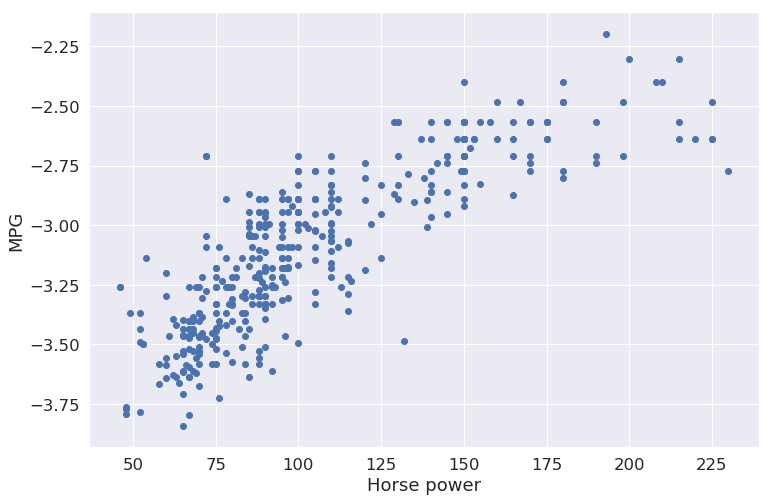

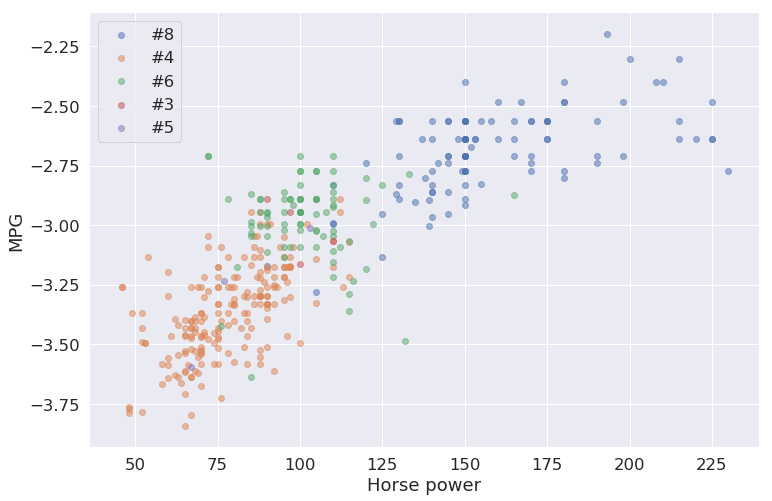

In [52]:
plt.figure(figsize=(12, 8))
plt.scatter(auto_mpg['Horse_power'], auto_mpg['MPG'])
plt.xlabel('Horse power')
plt.ylabel('MPG')
plt.show()

plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter(auto_mpg['Horse_power'][auto_mpg.Cylinders==cylinder], 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], alpha=0.5, 
                label='#{}'.format(cylinder))
plt.xlabel('Horse power')
plt.ylabel('MPG')
plt.legend()
plt.show()

##### Посмотрим на распределение MPG от веса двигателя

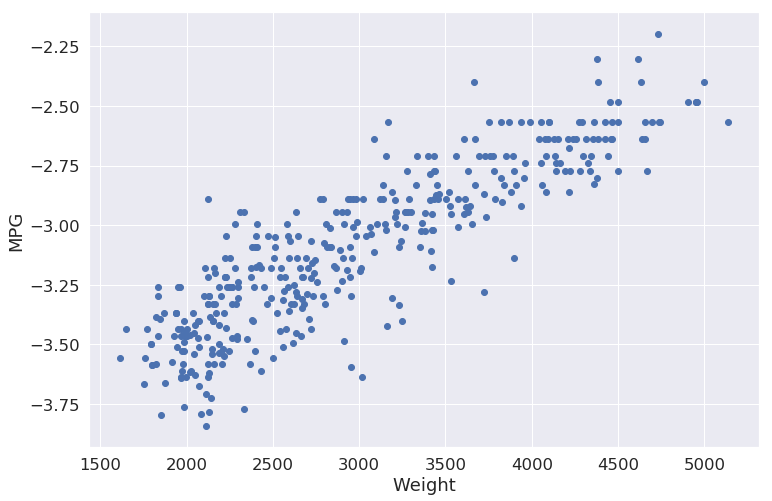

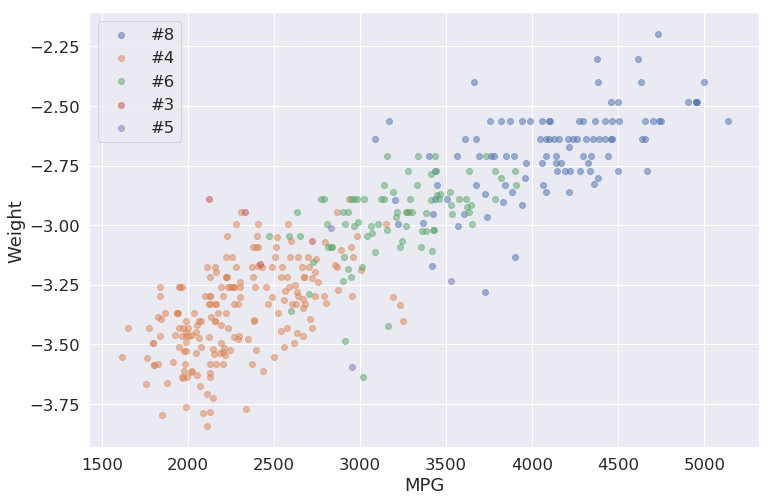

In [53]:
plt.figure(figsize=(12, 8))
plt.scatter(auto_mpg['Weight'], auto_mpg['MPG'])
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.show()

plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter(auto_mpg['Weight'][auto_mpg.Cylinders==cylinder], 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], 
                alpha=0.5, label='#{}'.format(cylinder))
plt.xlabel('MPG')
plt.ylabel('Weight')
plt.legend()
plt.show()

##### Посмотрим на распределение MPG от числа цилиндров

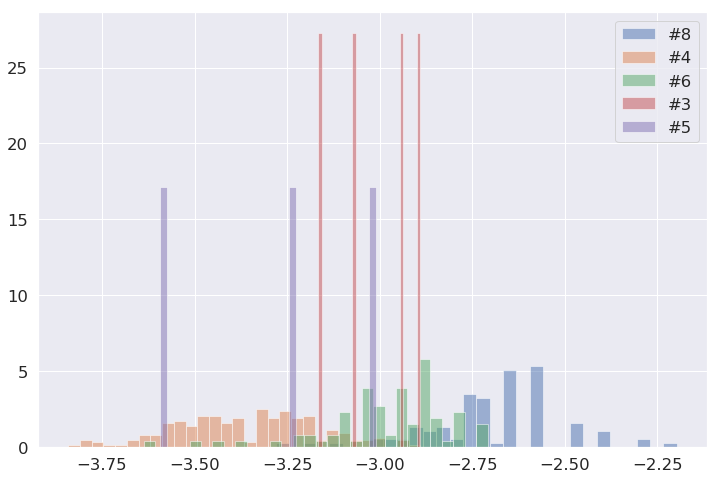

<Figure size 432x288 with 0 Axes>

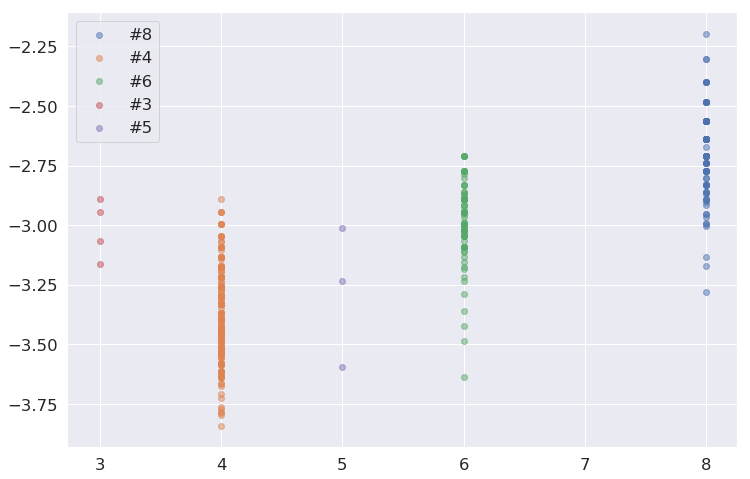

In [54]:
plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.hist(auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], 
             bins=30, alpha=0.5, label='#{}'.format(cylinder), density=True)
plt.legend()
plt.show()

fig = plt.figure()
plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter([cylinder] * len(auto_mpg['MPG'][auto_mpg.Cylinders==cylinder]), 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], alpha=0.5, 
            label='#{}'.format(cylinder))
plt.legend()
plt.show()

##### Посмотрим на распределение MPG от страны производителя

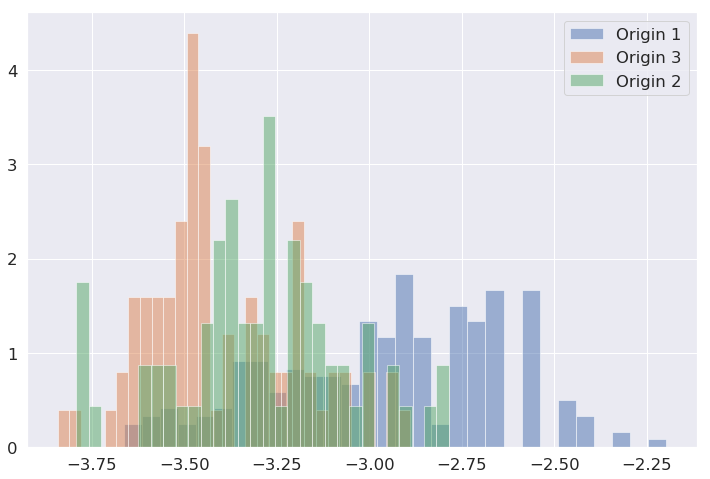

<Figure size 432x288 with 0 Axes>

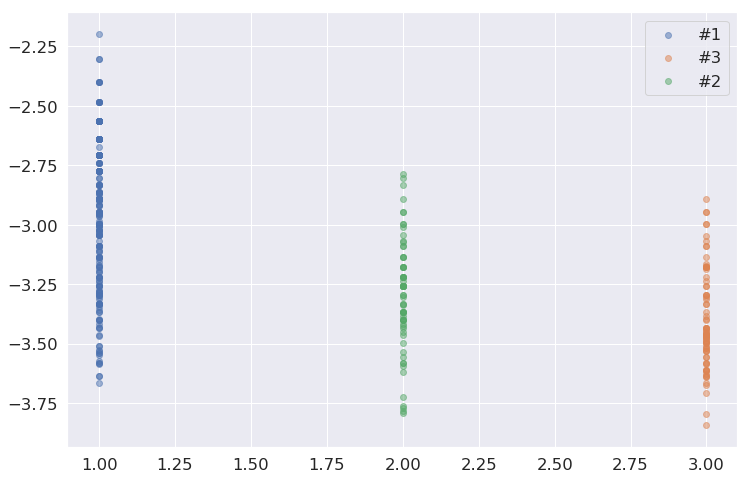

In [55]:
plt.figure(figsize=(12, 8))
for origin in auto_mpg.Origin.unique():
    plt.hist(auto_mpg['MPG'][auto_mpg.Origin==origin], 
             bins=30, alpha=0.5, label='Origin {}'.format(origin), density=True)
plt.legend()
plt.show()

fig = plt.figure()
plt.figure(figsize=(12, 8))
for origin in auto_mpg.Origin.unique():
    plt.scatter([origin] * len(auto_mpg['MPG'][auto_mpg.Origin==origin]), 
                auto_mpg['MPG'][auto_mpg.Origin==origin], alpha=0.5, 
                label='#{}'.format(origin))
plt.legend()
plt.show()

## F-test & ANOVA

F-распределение(распределение Фишера):

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a55e68498f7fd2c02998e8692ce340c3e9a5cedf)


Параметризуется двумя величинами: $d_1$ и $d_2$, которые называют степенями свободы.


Почему степенями свободы? Потому что распределение Фишера можно получить разделив два хи-квадрата друг на друга:

$$F=\frac{\chi^2(d_1) / d_1}{\chi^2(d_2) / d_2}$$

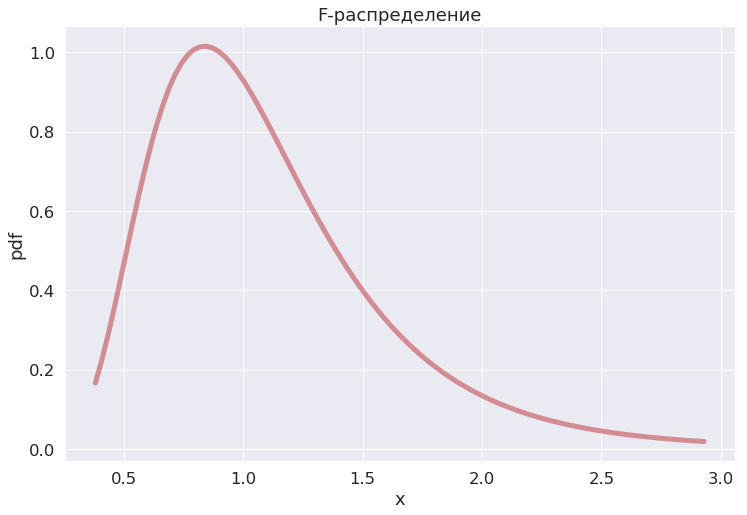

In [56]:
from scipy.stats import f
dfn, dfd = 29, 18

x = np.linspace(f.ppf(0.01, dfn, dfd),
                f.ppf(0.99, dfn, dfd), 100)

plt.figure(figsize=(12, 8))

plt.plot(x, f.pdf(x, dfn, dfd), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.title('F-распределение')

plt.xlabel('x')
plt.ylabel('pdf')

plt.show()

## Самая главная табличка ANOVA


#### Какую гипотезу мы проверяем?

$$\mathbb{H}_0:~~\textrm{все средние равны}$$  $$~~\mathrm{vs}~~$$  $$\mathbb{H}_1: ~~ \textrm{не все средние равны}$$

#### Для этого мы первым делом строим табличку вариаций

| Тип вариации  |  SS | df  | MS  | F  |
|---|---|---|---|---|
| Между групп  | SSG | k - 1 | MSG = SSG / (k - 1)  |  MSG / MSE |
| Внутри группами  | SSE  | n - k  | MSE = SSE / (n - k)  |   |
| Полная  |  SST | n - 1  |   |   |


Что значит каждый тип вариации?

  * Между группами(MSG): вариация между средними подсчитанными для каждой из группы и глобальным средним;
  * Внутри групп(MSE): вариация между измерениями и групповыми средними;
  * Полная: вариация между измерениями и глобальным средним.

#### После чего мы считаем F-стастистику:


$$F = \frac{MSG}{MSE}$$

#### И после этого мы  можем тестировать гипотезу:

Если нулевая гипотеза гипотеза верна, то $F$-статистика должна иметь F-распределение со степенями свободы $k-1$ и $n - k$.

Если $P(F_{k-1, n - k} > F) < \alpha$, то $H_0$ отклоняется.

# ANOVA в `statsmodels`

In [57]:
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

Зафитируем линейную модель по зависимости MPG от количества цилиндров:

In [58]:
formula = 'MPG ~ C(Cylinders)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     235.6
Date:                Wed, 13 Feb 2019   Prob (F-statistic):          2.71e-102
Time:                        17:15:32   Log-Likelihood:                 109.01
No. Observations:                 392   AIC:                            -208.0
Df Residuals:                     387   BIC:                            -188.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.0171      0.09

##### То как видит данные линейная модель

In [59]:
lm.model.data.orig_exog[:5]

,Intercept,C(Cylinders)[T.4],C(Cylinders)[T.5],C(Cylinders)[T.6],C(Cylinders)[T.8]
0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0


In [60]:
infl = lm.get_influence()
infl.summary_table()

obs,endog,fitted,Cook's,student.,hat diag,dffits,ext.stud.,dffits
,,value,d,residual,,internal,residual,
0.0,-2.890371757896165,-2.689076721697835,0.002359208136254759,-1.096902980892077,0.009708737864077693,-0.10860957914140812,-1.0971918079630187,-0.10863817728287194
1.0,-2.70805020110221,-2.689076721697835,2.0960135529982913e-05,-0.1033908560767891,0.009708737864077641,-0.010237220211068753,-0.10325861586437662,-0.01022412647892846
2.0,-2.890371757896165,-2.689076721697835,0.0023592081362547542,-1.096902980892077,0.009708737864077673,-0.10860957914140801,-1.0971918079630187,-0.10863817728287183
3.0,-2.772588722239781,-2.689076721697835,0.00040606719067824617,-0.45507611148675486,0.009708737864077678,-0.04505924936559896,-0.4546094307848798,-0.04501304109056734
4.0,-2.833213344056216,-2.689076721697835,0.0012096195786145292,-0.7854336287003566,0.009708737864077673,-0.07776951776289116,-0.7850441583180978,-0.0777309544486856
5.0,-2.70805020110221,-2.689076721697835,2.0960135529982977e-05,-0.1033908560767891,0.009708737864077669,-0.010237220211068768,-0.10325861586437662,-0.010224126478928475
6.0,-2.639057329615259,-2.689076721697835,0.0001456722889766948,0.2725671795688438,0.009708737864077669,0.026988172314617268,0.272240930273865,0.02695586882083515
7.0,-2.639057329615259,-2.689076721697835,0.0001456722889766948,0.2725671795688438,0.009708737864077669,0.026988172314617268,0.272240930273865,0.02695586882083515
8.0,-2.639057329615259,-2.689076721697835,0.0001456722889766948,0.2725671795688438,0.009708737864077669,0.026988172314617268,0.272240930273865,0.02695586882083515


Теперь построим ошибки(residuals).

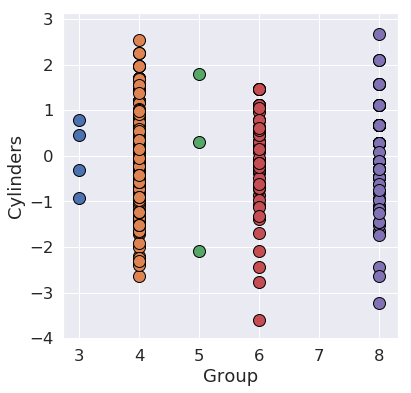

In [61]:
resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Cylinders']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Cylinders');

In [62]:
anova_table = anova_lm(lm)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,32.049300,8.012325,235.608959,2.709276e-102
Residual,387.0,13.160661,0.034007,NaN,NaN


##### Построим ошибки как функцию от веса двигателя

Кажется, что есть лёгкий тренд?..

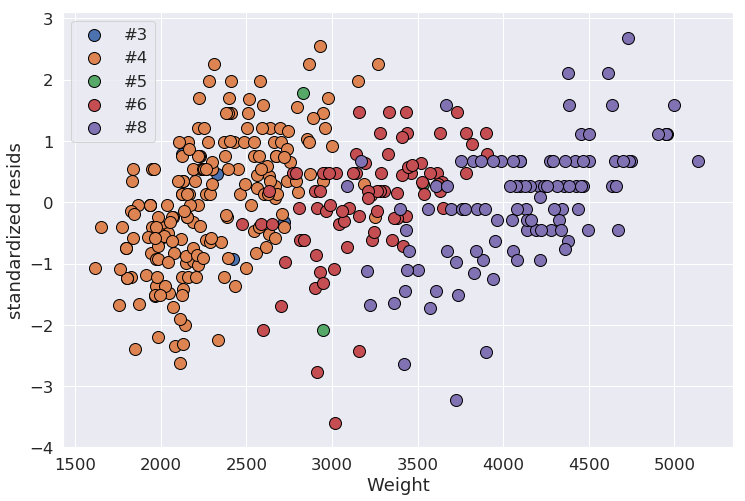

In [63]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Cylinders']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='#{}'.format(cylinder))
plt.xlabel('Weight');
plt.ylabel('standardized resids');
plt.legend();

#### Проделаем тоже самое, но со страной-производителем

In [64]:
formula = 'MPG ~ C(Origin)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     96.10
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           1.21e-34
Time:                        17:15:34   Log-Likelihood:                -54.177
No. Observations:                 392   AIC:                             114.4
Df Residuals:                     389   BIC:                             126.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.9491      0.018   -165.

In [65]:
anova_table = anova_lm(lm)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,14.950773,7.475386,96.10057,1.212555e-34
Residual,389.0,30.259188,0.077787,NaN,NaN


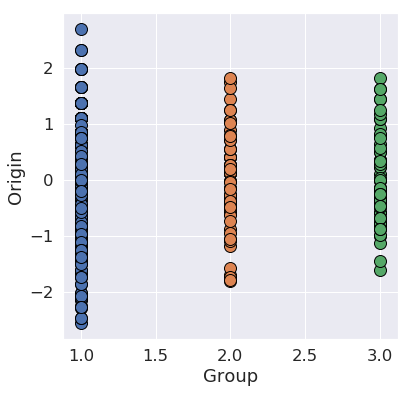

In [66]:
infl = lm.get_influence()

resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

##### Построим ошибки как функцию от веса двигателя
#### ОГО! А тут мы видим явный тренд

Что это может означать? 

  * То что различие может лежать не в том, что одни страны закладывают бОльшее потребление топлива при конструкции двигателя, а другие мЕньшее. 
  * А что одни страны производят более тяжёлые двигатели, чем другие.
  * Тогда вопрос: если откалиброваться на вес двигателя, то останется ли гипотеза о различии об MPG для разных стран верной?

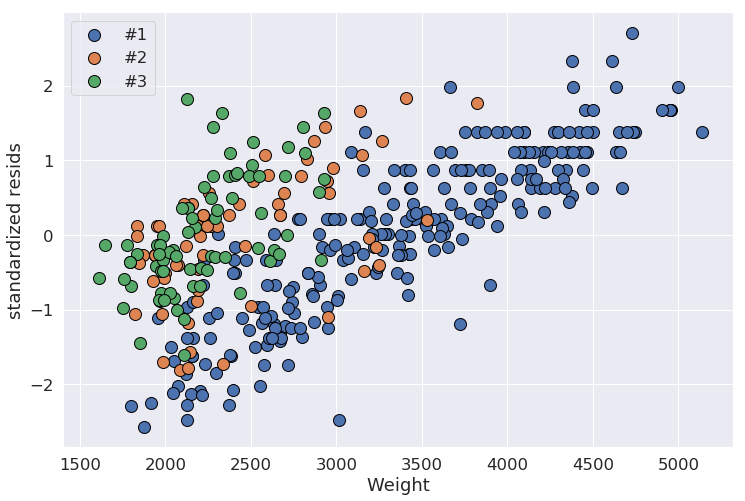

In [67]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Origin']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='#{}'.format(cylinder))
plt.xlabel('Weight');
plt.ylabel('standardized resids');
plt.legend();

# Two-Way ANOVA

In [68]:
formula = 'MPG ~ C(Cylinders) + C(Origin) + C(Cylinders) * C(Origin)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     128.2
Date:                Wed, 13 Feb 2019   Prob (F-statistic):          2.26e-103
Time:                        17:15:35   Log-Likelihood:                 122.39
No. Observations:                 392   AIC:                            -226.8
Df Residuals:                     383   BIC:                            -191.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [69]:
anova_table = anova_lm(lm, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,32.049300,8.012325,249.657091,2.766625e-105
C(Origin),2.0,0.843395,0.421697,13.139720,3.025162e-06
C(Cylinders):C(Origin),8.0,0.185660,0.023208,0.723127,6.711233e-01
Residual,383.0,12.291742,0.032093,NaN,NaN


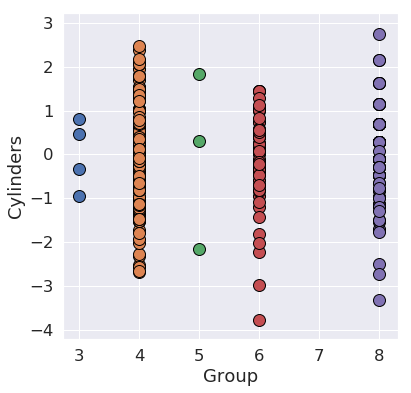

In [70]:
infl = lm.get_influence()

resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Cylinders']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Cylinders');

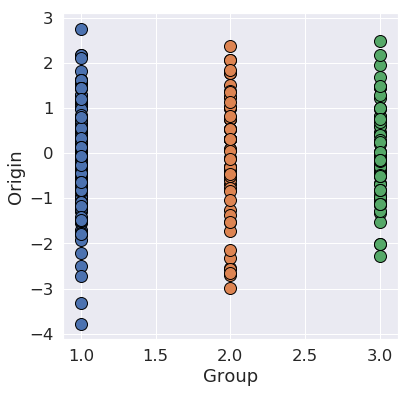

In [71]:
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

## А теперь чуть больше информации о том что происходит

### Как считается F-статистика?

$$F = \frac{SSE_R - SSE_F}{df_R - df_F} \frac{df_F}{SSE_F},$$

где индекс $F$ обозначает полную модель, а индекс $R$ обозначает усечённую модель.

### Три способа ввести полную и усечённую модель

Если у нас есть два фактора(страна и тип двигателя), то мы можем выписать СЕМЬ моделей:

$$1.~~  y_{ijk} = \mu + \alpha_j + \beta_k + (\alpha \beta)_{jk} + \epsilon_{ijk}$$

$$2.~~  y_{ijk} = \mu + \alpha_j + \beta_k + \epsilon_{ijk}$$

$$3.~~  y_{ijk} = \mu + \alpha_j + (\alpha \beta)_{jk} + \epsilon_{ijk}$$

$$4.~~  y_{ijk} = \mu  + \beta_k + (\alpha \beta)_{jk} + \epsilon_{ijk}$$

$$5.~~  y_{ijk} = \mu + \alpha_j + \epsilon_{ijk}$$

$$6.~~  y_{ijk} = \mu + \beta_k + \epsilon_{ijk}$$

$$7.~~  y_{ijk} = \mu + \epsilon_{ijk}$$



В литературе встречаются три способа выбрать R и F, которые обозначаются как I, II и III(неофициальная, но широко используемая терминология).

##### Type I.

Ещё называется "sequentional" моделью. Показывает сколько дополнительной дисперсии объяснено при добавлении новых переменных. 

  * Главный эффект от фактора A: F=5, R=7
  
    SS(A)
    
    
  * Главный эффект от фактора B: F=2, R=5
  
    SS(B | A)
    
    
  * Взаимодействие эффектов: F=1, R=2
  
    SS(AB | A, B)
    
    
###### Type II.

Сколько дисперсии объясняет новая переменная, когда все остальные уже включены.

  * Главный эффект от фактора A: F=2, R=6
    
    SS(A | B)
    
    
  * Главный эффект от фактора B: F=2, R=5
  
    SS(B | A)
    
    
  * Взаимодействие эффектов: F=1, R=2
  
    SS(AB | A, B)
  
###### Type III. 

Сколько дисперсии объясняет новая переменная, когда все остальные уже включены, включая interaction term.


  * Главный эффект от фактора A: F=1, R=4
    
    SS(A | A, AB)
    
    
  * Главный эффект от фактора B: F=1, R=3
    
    SS(B | A, AB)
    
    
  * Взаимодействие эффектов: F=1, R=2
  
    SS(AB | A, B)
    
    
http://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html

In [72]:
formula = 'MPG ~ C(Cylinders) * C(Origin)'
lm = ols(formula, auto_mpg).fit()

In [73]:
import IPython
for typ in ['I', 'II', 'III']:
    anova_table = anova_lm(lm, typ=typ)
    IPython.display.display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,32.049300,8.012325,249.657091,2.766625e-105
C(Origin),2.0,0.843395,0.421697,13.139720,3.025162e-06
C(Cylinders):C(Origin),8.0,0.185660,0.023208,0.723127,6.711233e-01
Residual,383.0,12.291742,0.032093,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Cylinders),477.079137,4.0,3716.342982,1.511351e-251
C(Origin),3.878695,2.0,60.428388,7.109457e-14
C(Cylinders):C(Origin),6.914210,8.0,26.930097,2.402991e-23
Residual,12.291742,383.0,NaN,NaN


,sum_sq,df,F,PR(>F)
Intercept,138.684365,1.0,4321.284456,1.067685e-210
C(Cylinders),21.422640,4.0,166.877720,1.489842e-82
C(Origin),2.562705,2.0,39.925828,1.780149e-16
C(Cylinders):C(Origin),6.914210,8.0,26.930097,2.402991e-23
Residual,12.291742,383.0,NaN,NaN


# ANCOVA

В ANCOVA(Analysis of covariance) добавляется ещё регрессия от некоторой величины, которая может оказывать влияние на интересующие нас переменные.

Если мы правильно выбрали регрессор, то вариация остатков должна уменьшиться.

Но при этом возможно увеличение дисперсии.

In [74]:
lm = ols("MPG ~ C(Origin) * Weight", auto_mpg).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     261.6
Date:                Wed, 13 Feb 2019   Prob (F-statistic):          1.47e-121
Time:                        17:15:35   Log-Likelihood:                 157.02
No. Observations:                 392   AIC:                            -302.0
Df Residuals:                     386   BIC:                            -278.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.0905      0.046    -89.788      0.000      -4.180      -4.001
C(Origin)[T.2]            0.1448      0.111      1.310      0.191      -0.073       0.362
C(Origin)[T.3]           -0.1298      0.137     -0.945      0.345      -0.400       0.140
Weight                    0.0003   1.31e-05     25.739      0.000       0.000       0.000
C(Origin)[T.2]:Weight -6.941e-05   4.27e-05     -1.627      0.105      -0.000    1.45e-05
C(Origin)[T.3]:Weight  3.294e-05   5.92e-05      0.556      0.578   -8.34e-05       0.000
==============================================================================
Omnibus:                        4.668   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                5.361
Skew:                          -0.122   Prob(JB):                       0.0685
Kurtosis:                       3.518   Cond. No.                     5.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
anova_table = anova_lm(lm, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,215.146957,1.0,8061.925222,9.269477e-261
C(Origin),0.080165,2.0,1.501952,2.239936e-01
Weight,17.680040,1.0,662.501398,8.890714e-86
C(Origin):Weight,0.082622,2.0,1.547988,2.139927e-01
Residual,10.301103,386.0,NaN,NaN


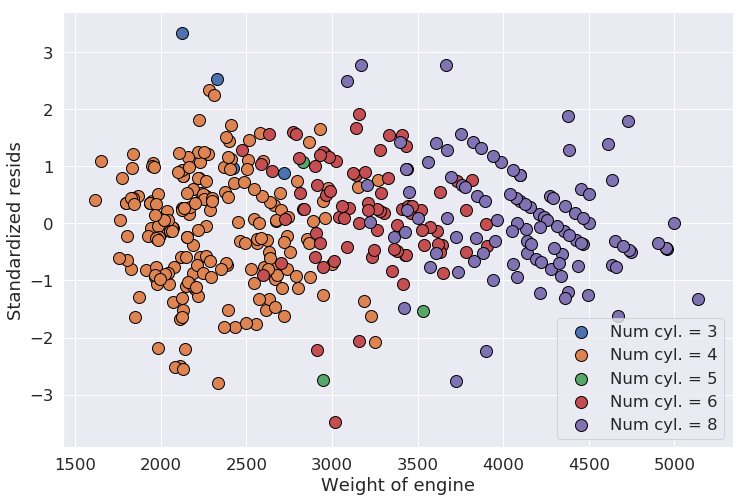

In [76]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Cylinders']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='Num cyl. = {}'.format(cylinder))
plt.xlabel('Weight of engine');
plt.ylabel('Standardized resids');
plt.legend();

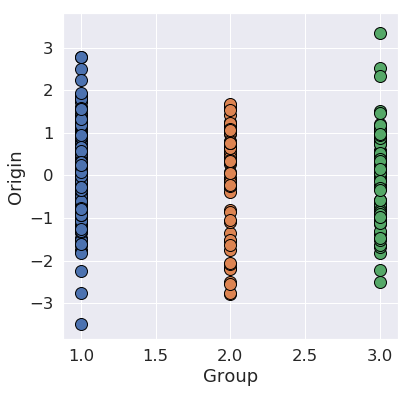

In [77]:
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

In [78]:
import IPython
for typ in ['I', 'II', 'III']:
    anova_table = anova_lm(lm, typ=typ)
    IPython.display.display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,14.950773,7.475386,280.115536,6.980543e-76
Weight,1.0,19.875463,19.875463,744.767679,4.062089e-92
C(Origin):Weight,2.0,0.082622,0.041311,1.547988,2.139927e-01
Residual,386.0,10.301103,0.026687,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Origin),0.160266,2.0,3.002717,5.081324e-02
Weight,19.875463,1.0,744.767679,4.062089e-92
C(Origin):Weight,0.082622,2.0,1.547988,2.139927e-01
Residual,10.301103,386.0,NaN,NaN


,sum_sq,df,F,PR(>F)
Intercept,215.146957,1.0,8061.925222,9.269477e-261
C(Origin),0.080165,2.0,1.501952,2.239936e-01
Weight,17.680040,1.0,662.501398,8.890714e-86
C(Origin):Weight,0.082622,2.0,1.547988,2.139927e-01
Residual,10.301103,386.0,NaN,NaN


## Three-Way ANCOVA

In [79]:
lm = ols("MPG ~ C(Origin) * Weight * Horse_power", auto_mpg).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     157.0
Date:                Wed, 13 Feb 2019   Prob (F-statistic):          6.69e-134
Time:                        17:15:36   Log-Likelihood:                 202.88
No. Observations:                 392   AIC:                            -381.8
Df Residuals:                     380   BIC:                            -334.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -4.5484      0.139    -32.722      0.000      -4.822      -4.275
C(Origin)[T.2]                        1.3664      0.395      3.463      0.001       0.591       2.142
C(Origin)[T.3]                       -0.3244      0.537     -0.604      0.546      -1.380       0.731
Weight                                0.0004   4.12e-05      9.623      0.000       0.000       0.000
C(Origin)[T.2]:Weight                -0.0007      0.000     -4.214      0.000      -0.001      -0.000
C(Origin)[T.3]:Weight             -7.332e-05      0.000     -0.301      0.763      -0.001       0.000
Horse_power                           0.0069      0.001      4.814      0.000       0.004       0.010
C(Origin)[T.2]:Horse_power           -0.0113      0.005     -2.344      0.020      -0.021      -0.002
C(Origin)[T.3]:Horse_power            0.0136      0.007      1.989      0.047       0.000       0.027
Weight:Horse_power                  -1.3e-06   3.46e-07     -3.759      0.000   -1.98e-06    -6.2e-07
C(Origin)[T.2]:Weight:Horse_power  5.663e-06   1.77e-06      3.193      0.002    2.18e-06    9.15e-06
C(Origin)[T.3]:Weight:Horse_power -3.515e-06   2.72e-06     -1.294      0.196   -8.86e-06    1.82e-06
==============================================================================
Omnibus:                        3.421   Durbin-Watson:                   1.076
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.674
Skew:                          -0.094   Prob(JB):                        0.159
Kurtosis:                       3.436   Cond. No.                     2.96e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

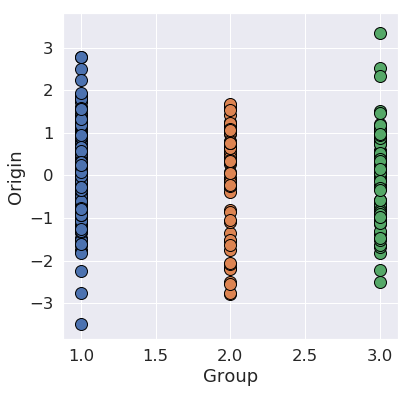

In [80]:
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

In [81]:
import IPython
for typ in ['I', 'II', 'III']:
    anova_table = anova_lm(lm, typ=typ)
    IPython.display.display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,14.950773,7.475386,348.449569,1.110779e-86
Weight,1.0,19.875463,19.875463,926.453351,6.123132e-104
C(Origin):Weight,2.0,0.082622,0.041311,1.925619,1.472053e-01
Horse_power,1.0,1.009828,1.009828,47.071022,2.790999e-11
C(Origin):Horse_power,2.0,0.632380,0.316190,14.738547,6.843162e-07
Weight:Horse_power,1.0,0.247390,0.247390,11.531567,7.564492e-04
C(Origin):Weight:Horse_power,2.0,0.259259,0.129629,6.042403,2.610242e-03
Residual,380.0,8.152247,0.021453,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Origin),0.179294,2.0,4.178716,1.602785e-02
Weight,2.914269,1.0,135.842566,4.775279e-27
C(Origin):Weight,0.477499,2.0,11.128802,2.009433e-05
Horse_power,1.009828,1.0,47.071022,2.790999e-11
C(Origin):Horse_power,0.273282,2.0,6.369243,1.902066e-03
Weight:Horse_power,0.247390,1.0,11.531567,7.564492e-04
C(Origin):Weight:Horse_power,0.259259,2.0,6.042403,2.610242e-03
Residual,8.152247,380.0,NaN,NaN


,sum_sq,df,F,PR(>F)
Intercept,22.970668,1.0,1070.729894,1.363799e-112
C(Origin),0.275520,2.0,6.421403,1.808467e-03
Weight,1.986808,1.0,92.610936,9.210952e-20
C(Origin):Weight,0.381277,2.0,8.886227,1.691569e-04
Horse_power,0.497086,1.0,23.170615,2.143163e-06
C(Origin):Horse_power,0.215915,2.0,5.032212,6.965915e-03
Weight:Horse_power,0.303122,1.0,14.129400,1.974849e-04
C(Origin):Weight:Horse_power,0.259259,2.0,6.042403,2.610242e-03
Residual,8.152247,380.0,NaN,NaN


## Неожиданно важный момент в конце тетрадки
## Тестирование предположений ANCOVA

  * Зависимость между x и y линейная;
  * Зависимость между x и y одинаковая для разных групп(параллельность);
  * __Независимость x от группы__(потому что условия в которых находятся испытуемые должны быть одинаковы);
  * $y | x ~ \mathcal{N}(\mu + \alpha_j + \beta(x_{ij} - \bar{x}), \sigma^2)$ -- гомогенность дисперсии.

#### 1. Линейная зависимость от "ковариации" того что мы хотим предсказывать

In [82]:
lm = ols("MPG ~ Weight", auto_mpg).fit()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
Weight,1.0,34.665970,34.665970,1282.221169,2.392115e-125
Residual,390.0,10.543991,0.027036,NaN,NaN


p-value равно нулю, как и std err, поэтому первое предположение верно.

#### 2. Параллельность наклонов

In [83]:
lm = ols("MPG ~ Weight * C(Origin)", auto_mpg).fit()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,14.950773,7.475386,280.115536,6.980543e-76
Weight,1.0,19.875463,19.875463,744.767679,4.062089e-92
Weight:C(Origin),2.0,0.082622,0.041311,1.547988,2.139927e-01
Residual,386.0,10.301103,0.026687,NaN,NaN


`p-value` =  0.00435, что, вообще говоря, не очень хорошо.

Мы бы ожидали увидеть здесь большое `p-value`, что означало бы, что предположение о параллельности наклонов выполняется.

#### 3. Тестирование на наличие зависимости "ковариации" от категориальной фичи 

In [84]:
lm = ols("Weight ~ C(Origin)", auto_mpg).fit()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,1.035338e+08,5.176691e+07,112.772038,2.353054e-39
Residual,389.0,1.785667e+08,4.590403e+05,NaN,NaN


Очень сильная зависимость между весом и страной-производителем, что тоже не соответствует предположениям ANOVA.

#### 4. Тестирование  гипотезы о гомогенности дисперсии

https://en.wikipedia.org/wiki/Levene%27s_test

In [85]:
from scipy.stats import levene

In [86]:
levene?

In [87]:
levene(auto_mpg[auto_mpg.Origin==1].MPG,
       auto_mpg[auto_mpg.Origin==2].MPG,
       auto_mpg[auto_mpg.Origin==3].MPG)

LeveneResult(statistic=11.084787110808314, pvalue=2.0802654412599575e-05)

Тест о гомогенности дисперсии пройден :)

##### Очень важно тестировать эти предположения перед проведением теста, так как верность предпосылок напрямую влияет на достоверность выводов